In [2]:
import numpy as np
from Bio import SeqIO
import os
import pandas as pd
import torch
import seaborn as sns
import math
import scipy.stats as stats
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
from numpy import trapz
from sklearn.metrics import auc
from pathlib import Path

sns.set(font_scale=1.6, style="ticks")

In [3]:
runs_folder = Path("../../../runs")
data_folder = Path("../../../data/gisaid/flu/ha_processed_continents")
saving_dir = Path("figs")

saving_dir.mkdir(parents=True, exist_ok=True)

# NLL & revNLL

In [5]:
subtype = "a_h3n2"
continents = ("north_america", "africa", "south_america", "asia", "europe", "oceania")

def get_nlls(df):
    if "token_num" not in df:
        df["token_num"] = np.asarray([566] * len(df), dtype=np.float32)
    m = df.pivot(index='src_id', columns='src_time', values='prediction')
    m = torch.tensor(m.to_numpy())
    nlls = - (torch.logsumexp(-m, dim=-1) - math.log(m.size(1))) 
    token_num = torch.tensor(df.pivot(index='src_id', columns='src_time', values='token_num').to_numpy())
    token_num = torch.mean(token_num.float(), dim=1)
    freqs = torch.tensor(df.pivot(index='src_id', columns='src_time', values='freq').to_numpy())
    if torch.all(torch.isnan(freqs)):
        freqs = torch.ones(freqs.size()) / freqs.size(0)
    freqs = torch.mean(freqs, dim=1)
    nll = torch.sum((freqs * nlls)) / torch.sum(freqs * token_num)
    return nll, sum(nlls)

nll_results = defaultdict(list)
testing_years = list(range(2015, 2019))
for rev_nll_model_seed in ("1005", "529", "1213"): # "529", "1213"
    print(">>> seed", rev_nll_model_seed)
    for year in testing_years:
        print(year)
        location2bin_size = dict()
        for continent in continents:
            index = (year - 2018) * 2 + 30
            virus_fasta_path= data_folder / ("2003-10_to_2023-04_6M/a_h3n2/continents/human_minBinSize10_minLen553_%s_location_bins/%d.fasta" % (continent, index))
            if not os.path.exists(virus_fasta_path):
                continue
            records = SeqIO.parse(virus_fasta_path, "fasta")
            for record in records:
                description = record.description.split()[1]
                bin_size = int({x.split("=")[0]: x.split("=")[1] for x in description.split("|")}["bin_size"])
            location2bin_size[continent] = bin_size

        for temperature in (0.2, 0.4, 0.6, 0.8, 1.0):
            for continent in continents:

                name2nll_path = {
                    "Global": runs_folder / ("flu_ah3n2_continents/2003-10_to_%d-02_2M/global/test/%s/temp_%.1lf/test_results.csv" % (year, continent, temperature)),
                    "Transmission (with reg)": runs_folder / ("flu_ah3n2_continents/2003-10_to_%d-02_2M/transmission/test/%s/temp_%.1lf/lightning_logs/version_0/test_results.csv" % (year, continent, temperature)),
                    "Transmission (no reg)": runs_folder / ("flu_ah3n2_continents/2003-10_to_%d-02_2M/transmission_ablation/no_reg/test/%s/temp_%.1lf/test_results.csv" % (year, continent, temperature)),
                    "no reg, shuffle": runs_folder / ("flu_ah3n2_continents/2003-10_to_%d-02_2M/transmission_ablation/no_reg_shuffle/test/%s/temp_%.1lf/test_results.csv" % (year, continent, temperature)),
                    "no reg, top-3 eig": runs_folder / ("flu_ah3n2_continents/2003-10_to_%d-02_2M/transmission_ablation/no_reg_top3_eig/test/%s/temp_%.1lf/test_results.csv" % (year, continent, temperature)),                    
                }

                name2rev_nll_path = {                    
                    "Global": runs_folder / ("flu_ah3n2_continents/2003-10_to_%d-02_2M/global/test_rev_seed%s/%s/temp_%.1lf/lightning_logs/version_0/test_results.csv" % (year, rev_nll_model_seed, continent, temperature)),
                    "Transmission (with reg)": runs_folder / ("flu_ah3n2_continents/2003-10_to_%d-02_2M/transmission/test_rev_seed%s/%s/temp_%.1lf/lightning_logs/version_0/test_results.csv" % (year, rev_nll_model_seed, continent, temperature)),
                    "Transmission (no reg)": runs_folder / ("flu_ah3n2_continents/2003-10_to_%d-02_2M/transmission_ablation/no_reg/test_rev_seed%s/%s/temp_%.1lf/lightning_logs/version_0/test_results.csv" % (year, rev_nll_model_seed, continent, temperature)),
                    "no reg, shuffle": runs_folder / ("flu_ah3n2_continents/2003-10_to_%d-02_2M/transmission_ablation/no_reg_shuffle/test_rev_seed%s/%s/temp_%.1lf/lightning_logs/version_0/test_results.csv" % (year, rev_nll_model_seed, continent, temperature)),
                    "no reg, top-3 eig": runs_folder / ("flu_ah3n2_continents/2003-10_to_%d-02_2M/transmission_ablation/no_reg_top3_eig/test_rev_seed%s/%s/temp_%.1lf/lightning_logs/version_0/test_results.csv" % (year, rev_nll_model_seed, continent, temperature)),

                }

                for name, _path in name2nll_path.items():
                    our_model_path_nll = name2nll_path[name]
                    our_model_path_rev_nll = name2rev_nll_path[name]

                    if os.path.exists(our_model_path_rev_nll) and os.path.exists(our_model_path_nll):
                        df = pd.read_csv(our_model_path_nll)
                        nll, sum_nll = get_nlls(df)
                        df = pd.read_csv(our_model_path_rev_nll)
                        rev_nll, sum_rev_nll = get_nlls(df)

                        nll_results["NLL"].append(nll.item())
                        nll_results["Year"].append(year)
                        nll_results["reverse NLL"].append(rev_nll.item())
                        nll_results["temperature"].append(temperature)
                        nll_results["continent"].append(continent)
                        nll_results["model"].append(name)
                        nll_results["bin_size"].append(location2bin_size[continent])
                        nll_results["oracle"].append(rev_nll_model_seed)

                    else:
                        if not os.path.exists(our_model_path_rev_nll):
                            print("path doesn't exist", our_model_path_rev_nll)

                        if not os.path.exists(our_model_path_nll):
                            print("path doesn't exist", our_model_path_nll)

nll_results = pd.DataFrame(nll_results)
print(nll_results)


>>> seed 1005
2015
2016
2017
2018
>>> seed 529
2015
2016
2017
2018
>>> seed 1213
2015
2016
2017
2018
           NLL  Year  reverse NLL  temperature      continent  \
0     0.153713  2015     0.004832          0.2  north_america   
1     0.149997  2015     0.004843          0.2  north_america   
2     0.150815  2015     0.004821          0.2  north_america   
3     0.145945  2015     0.004973          0.2  north_america   
4     0.151849  2015     0.004821          0.2  north_america   
...        ...   ...          ...          ...            ...   
1795  0.046096  2018     0.039956          1.0        oceania   
1796  0.055993  2018     0.023075          1.0        oceania   
1797  0.050009  2018     0.042826          1.0        oceania   
1798  0.049084  2018     0.042963          1.0        oceania   
1799  0.052090  2018     0.035088          1.0        oceania   

                        model  bin_size oracle  
0                      Global      1123   1005  
1     Transmission (

In [6]:
def get_summary(df, keys=("model", "temperature", "year"), weighted_average=True, nll_key="NLL", rev_nll_key="reverse NLL"):
    summary_nll_results = defaultdict(list)
    for x in zip(*(df[key] for key in keys)):
        _df = df
        for i, key in enumerate(keys):
            _df = _df[_df[key] == x[i]]
        
        if weighted_average:
            ave_nll = np.sum(_df["bin_size"] * _df[nll_key]) / np.sum(_df["bin_size"])
            ave_rev_nll = np.sum(_df["bin_size"] * _df[rev_nll_key]) / np.sum(_df["bin_size"])
        else:
            ave_nll = np.mean(_df[nll_key])
            ave_rev_nll = np.mean(_df[rev_nll_key])
        
        for i, key in enumerate(keys):
            summary_nll_results[key].append(x[i])
        summary_nll_results[nll_key].append(ave_nll)
        summary_nll_results[rev_nll_key].append(ave_rev_nll)
        summary_nll_results["toal_sample_size"].append(np.sum(_df["bin_size"]))


    summary_nll_results = pd.DataFrame(summary_nll_results)
    summary_nll_results = summary_nll_results.drop_duplicates()
    # print(summary_nll_results)
    return summary_nll_results

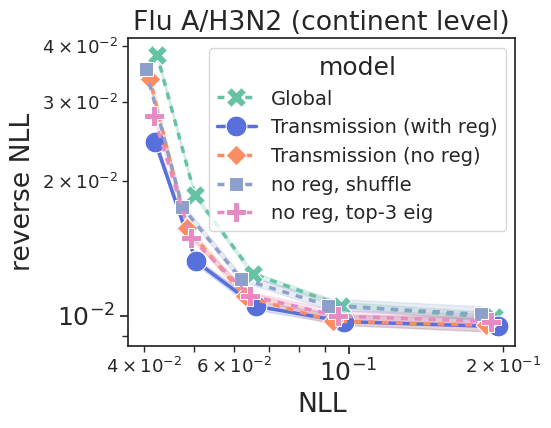

In [10]:
plt.xscale('log')
plt.yscale('log')

_nll_results = nll_results[nll_results["bin_size"] >= 200]

summary_summary_df = get_summary(_nll_results, keys=("model", "temperature","oracle"), weighted_average=False)

plt.rcParams['figure.figsize'] = 5, 4
plt.rcParams['lines.markersize'] = 15

models = list(set(summary_summary_df["model"]))
models.sort()
style_dict = {}
for model in models:
    if model == "Transmission (with reg)":
        style_dict[model] = ""
    else:
        style_dict[model] = (2,2)
        
style_order = models
style_order.remove("Transmission (with reg)")
style_order = ["Transmission (with reg)"] + style_order

if "Transmission (no reg)" in style_order:
    style_order.remove("Transmission (no reg)")
    style_order = style_order + ["Transmission (no reg)"]

palette_light = sns.color_palette("Set2", n_colors=8) # pastel
palette_dark = sns.color_palette("hls", n_colors=8)
color_dict = {}
for i, model in enumerate(models):
    color_dict[model] = palette_light[i]
color_dict["Transmission (with reg)"] = palette_dark[5]

ax = sns.lineplot(summary_summary_df, x="NLL", y="reverse NLL", hue="model", markers=True, # marker='o', 
                  sort=False,style="model",lw=2.5, dashes=style_dict,palette=color_dict,style_order=style_order) # , size=20 ,linewidth = 1.5

ax.set_title("Flu %s (continent level)" % (subtype.upper().replace("_", "/")))

ax.tick_params(axis='both', which='minor', labelsize=13)
ax.tick_params(axis='both', which='major', labelsize=18)

plt.legend(title="model",fontsize='14', title_fontsize='18')

plt.savefig(saving_dir / "ablation_flu_continent_average.pdf", format='pdf', bbox_inches='tight')
plt.show()